In [1]:
!pip install langchain langgraph langchain-google-genai google-generativeai

INFO: pip is looking at multiple versions of google-generativeai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of google-generativeai to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 966.6 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2

In [9]:
from google.colab import userdata

from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI

import operator

from typing import TypedDict, Annotated
from pydantic import BaseModel, Field

In [3]:
api_key = userdata.get("GOOGLE_API_KEY")

In [4]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash",
    google_api_key=api_key
)

In [6]:
class EvauationSchema(BaseModel):
  feedback: str = Field(description='Detailed feedback for the essay')
  score: int = Field(description='Score out of 10 for the essay', ge=0, le=10)

In [7]:
structured_model = llm.with_structured_output(EvauationSchema)

In [11]:
class EssayState(TypedDict):
  essay: str
  language_feedback: str
  depth_of_analysis_feedback: str
  clarity_of_thought_feedback: str
  overall_feedback: str
  individual_score: Annotated[list[int], operator.add]
  average_score: float

In [17]:
def evaluate_language(state: EssayState) -> EssayState:
  prompt = f"Evaluate the language quality of the following essay and provide a feedback and assign a score: \n {state['essay']}"
  output = structured_model.invoke(prompt)

  return {'language_feedback': output.feedback, 'individual_score': [output.score]}

In [18]:
def evaluate_depth_of_analysis(state: EssayState) -> EssayState:
  prompt = f"Evaluate the depth of analysis of the following essay and provide a feedback and assign a score: \n {state['essay']}"
  output = structured_model.invoke(prompt)

  return {'depth_of_analysis_feedback': output.feedback, 'individual_score': [output.score]}

In [19]:
def evaluate_clarity_of_thought(state: EssayState) -> EssayState:
  prompt = f"Evaluate the clarity of thought of the following essay and provide a feedback and assign a score: \n {state['essay']}"
  output = structured_model.invoke(prompt)

  return {'clarity_of_thought_feedback': output.feedback, 'individual_score': [output.score]}

In [20]:
def evaluate_essay(state: EssayState) -> EssayState:
  prompt = f'Based on the following feedbacks, create a summarized feedback: \n Language Feedback - {state["language_feedback"]} \n Depth of Analysis Feedback - {state["depth_of_analysis_feedback"]} \n Clarity of Thought Feedback - {state["clarity_of_thought_feedback"]}'
  overall_feedback = llm.invoke(prompt).content

  average_score = sum(state['individual_score']) / len(state['individual_score'])

  return {'overall_feedback': overall_feedback, 'average_score': average_score}

In [21]:
graph = StateGraph(EssayState)

In [22]:
graph.add_node('evaluate_language', evaluate_language)
graph.add_node('evaluate_depth_of_analysis', evaluate_depth_of_analysis)
graph.add_node('evaluate_clarity_of_thought', evaluate_clarity_of_thought)
graph.add_node('evaluate_essay', evaluate_essay)

In [23]:
graph.add_edge(START, 'evaluate_language')
graph.add_edge(START, 'evaluate_depth_of_analysis')
graph.add_edge(START, 'evaluate_clarity_of_thought')

graph.add_edge('evaluate_language', 'evaluate_essay')
graph.add_edge('evaluate_depth_of_analysis', 'evaluate_essay')
graph.add_edge('evaluate_clarity_of_thought', 'evaluate_essay')

graph.add_edge('evaluate_essay', END)

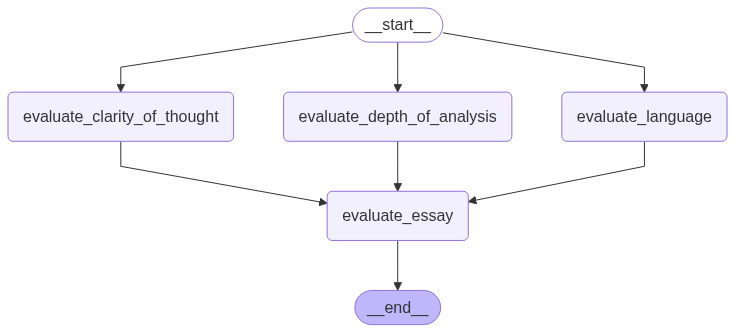

In [24]:
workflow = graph.compile()
workflow

In [25]:
essay = """
Artificial Intelligence (AI) is revolutionizing oncology by enhancing diagnosis, treatment planning, and patient outcomes. In cancer diagnostics, AI algorithms can analyze medical images, such as CT scans and mammograms, with remarkable accuracy, often identifying tumors earlier than traditional methods. Machine learning models trained on vast datasets can detect subtle patterns in imaging, histopathology slides, and genomic data, enabling personalized treatment strategies.
In precision oncology, AI facilitates the integration of genomic, proteomic, and clinical data to identify specific cancer subtypes and potential therapeutic targets. AI-driven platforms support oncologists in predicting patient responses to therapies, minimizing trial-and-error approaches, and reducing adverse effects. For instance, deep learning models can forecast tumor progression and recommend optimal chemotherapy regimens based on individual profiles.
Additionally, AI contributes to drug discovery by accelerating the identification of novel compounds and predicting their efficacy. Natural language processing tools extract valuable insights from biomedical literature and clinical records, assisting in real-time decision-making.
Despite its potential, AI in oncology faces challenges, including data privacy concerns, model interpretability, and the need for regulatory approval. Nevertheless, as technology advances and interdisciplinary collaboration grows, AI is poised to become a cornerstone of modern oncology, fostering earlier detection, tailored treatments, and improved survival rates for cancer patients.
"""

In [26]:
initial_state = {
    'essay': essay
}

final_state = workflow.invoke(initial_state)

In [27]:
print(final_state)

{'essay': '\nArtificial Intelligence (AI) is revolutionizing oncology by enhancing diagnosis, treatment planning, and patient outcomes. In cancer diagnostics, AI algorithms can analyze medical images, such as CT scans and mammograms, with remarkable accuracy, often identifying tumors earlier than traditional methods. Machine learning models trained on vast datasets can detect subtle patterns in imaging, histopathology slides, and genomic data, enabling personalized treatment strategies.\nIn precision oncology, AI facilitates the integration of genomic, proteomic, and clinical data to identify specific cancer subtypes and potential therapeutic targets. AI-driven platforms support oncologists in predicting patient responses to therapies, minimizing trial-and-error approaches, and reducing adverse effects. For instance, deep learning models can forecast tumor progression and recommend optimal chemotherapy regimens based on individual profiles.\nAdditionally, AI contributes to drug discove